### Project Title:
## Predicting Salaries in the Global AI Job Market Using Machine Learning
___

### 1. Import Libraries

Import all required libraries for data preparation, visualization, modeling, and evaluation.

In [195]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

### 2. Data Acquisition
This project uses a single primary dataset sourced from Kaggle containing AI job postings and standardized salary information in USD.

In [196]:
# Load dataset
ai_jobs_2025 = pd.read_csv("data/ai_job_dataset.csv")
ai_jobs_2025.sample(1)

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
13698,AI13699,Principal Data Scientist,112011,USD,MI,PT,Denmark,S,Denmark,50,"Hadoop, Python, Java, Mathematics",Bachelor,3,Retail,2025-04-03,2025-05-04,969,6.1,Quantum Computing Inc


### 3. Initial Data Inspection

Inspect structure, data types, and missingness to understand what cleaning and preprocessing are required.

In [197]:
ai_jobs_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  15000 non-null  object 
 1   job_title               15000 non-null  object 
 2   salary_usd              15000 non-null  int64  
 3   salary_currency         15000 non-null  object 
 4   experience_level        15000 non-null  object 
 5   employment_type         15000 non-null  object 
 6   company_location        15000 non-null  object 
 7   company_size            15000 non-null  object 
 8   employee_residence      15000 non-null  object 
 9   remote_ratio            15000 non-null  int64  
 10  required_skills         15000 non-null  object 
 11  education_required      15000 non-null  object 
 12  years_experience        15000 non-null  int64  
 13  industry                15000 non-null  object 
 14  posting_date            15000 non-null

In [198]:
ai_jobs_2025.head(3)

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech


### 4. Exploratory Data Analysis

Visualize salary distributions to assess skewness and justify log10 transformation for modeling.

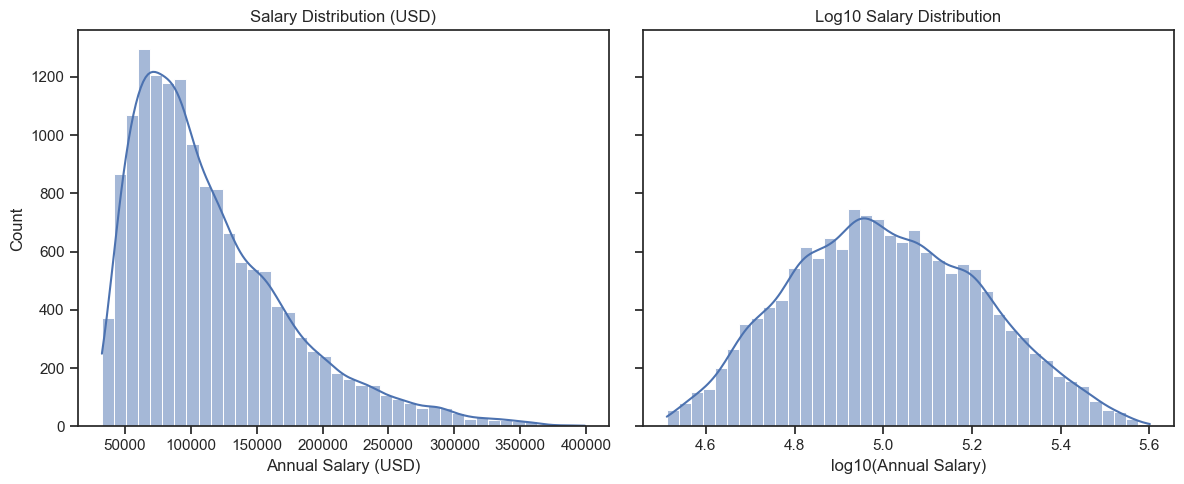

In [199]:
# Salary distribution (raw USD) and log10-transformed
# Salary data is typically right-skewed; log10 helps stabilize variance.

salary = pd.to_numeric(ai_jobs_2025.get("salary_usd"), errors="coerce")
salary = salary.dropna()
salary = salary[salary > 0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

sns.histplot(salary, bins=40, kde=True, ax=axes[0])
axes[0].set_title("Salary Distribution (USD)")
axes[0].set_xlabel("Annual Salary (USD)")

log_salary = np.log10(salary)
sns.histplot(log_salary, bins=40, kde=True, ax=axes[1])
axes[1].set_title("Log10 Salary Distribution")
axes[1].set_xlabel("log10(Annual Salary)")

plt.tight_layout()
plt.show()

### 5. Data Cleaning and Preparation

Standardize column names, coerce salary to numeric, remove invalid targets, standardize categorical text, and create the log-transformed target variable (`log_salary`).

In [200]:
def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = (
        df.columns.str.strip()
                 .str.lower()
                 .str.replace(" ", "_")
                 .str.replace("-", "_")
    )
    return df

ai_jobs_2025 = standardize_columns(ai_jobs_2025)

print("Standardized Columns:")
for col in ai_jobs_2025.columns:
    print(f" - {col}")

Standardized Columns:
 - job_id
 - job_title
 - salary_usd
 - salary_currency
 - experience_level
 - employment_type
 - company_location
 - company_size
 - employee_residence
 - remote_ratio
 - required_skills
 - education_required
 - years_experience
 - industry
 - posting_date
 - application_deadline
 - job_description_length
 - benefits_score
 - company_name


In [201]:
def clean_primary_dataset(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Ensure salary column exists
    if "salary_usd" not in df.columns:
        raise ValueError("Expected a 'salary_usd' column in the primary dataset.")

    # Coerce salary to numeric and remove invalid
    df["salary_usd"] = pd.to_numeric(df["salary_usd"], errors="coerce")
    df = df.dropna(subset=["salary_usd"])
    df = df[df["salary_usd"] > 0]

    # Standardize common categorical text fields
    cat_cols = [
        "experience_level", "employment_type", "company_location", "company_size",
        "industry", "education_required", "job_title"
    ]
    for c in cat_cols:
        if c in df.columns:
            df[c] = df[c].astype(str).str.strip()

    # Drop duplicates
    df = df.drop_duplicates()

    # Create log target
    df["log_salary"] = np.log10(df["salary_usd"])

    return df

ai_jobs_2025_clean = clean_primary_dataset(ai_jobs_2025)
ai_jobs_2025_clean.shape

(15000, 20)

#### 5.1 Salary Sanity Checks

Summarize salary ranges to detect extreme outliers and confirm target values are plausible.

In [202]:
ai_jobs_2025_clean["salary_usd"].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])

count     15000.000000
mean     115348.965133
std       60260.940438
min       32519.000000
1%        37268.670000
5%        46574.500000
50%       99705.000000
95%      237987.950000
99%      307775.690000
max      399095.000000
Name: salary_usd, dtype: float64

### 6. Feature Engineering

Create engineered predictors that capture domain-relevant salary drivers (experience tiers, grouped job titles, remote indicator, and skill counts).

In [203]:
def bucket_years_experience(x):
    if pd.isna(x):
        return np.nan
    x = float(x)
    if x < 2:
        return "Entry"
    elif x < 5:
        return "Junior"
    elif x < 10:
        return "Mid"
    elif x < 15:
        return "Senior"
    else:
        return "Lead"

def compute_skill_count(skills):
    if pd.isna(skills):
        return 0
    s = str(skills).strip()
    if s == "":
        return 0
    tokens = [t.strip() for t in s.split(",") if t.strip()]
    return len(tokens)

def feature_engineer(df: pd.DataFrame, top_n_titles: int = 25) -> pd.DataFrame:
    df = df.copy()

    # Experience bucket
    if "years_experience" in df.columns:
        df["years_experience"] = pd.to_numeric(df["years_experience"], errors="coerce")
        df["experience_bucket"] = df["years_experience"].apply(bucket_years_experience)

    # Group job titles
    if "job_title" in df.columns:
        top_titles = df["job_title"].value_counts().nlargest(top_n_titles).index
        df["job_title_grouped"] = df["job_title"].where(df["job_title"].isin(top_titles), "Other")

    # Remote indicator
    if "remote_ratio" in df.columns:
        df["remote_ratio"] = pd.to_numeric(df["remote_ratio"], errors="coerce").fillna(0)
        df["is_remote"] = (df["remote_ratio"] >= 80).astype(int)

    # Skill count
    if "required_skills" in df.columns:
        df["skill_count"] = df["required_skills"].apply(compute_skill_count)

    # Optional date features (only if columns exist)
    if "posting_date" in df.columns:
        posting_dt = pd.to_datetime(df["posting_date"], errors="coerce")
        df["posting_month"] = posting_dt.dt.month
        df["posting_dayofweek"] = posting_dt.dt.dayofweek

    if "posting_date" in df.columns and "application_deadline" in df.columns:
        posting_dt = pd.to_datetime(df["posting_date"], errors="coerce")
        deadline_dt = pd.to_datetime(df["application_deadline"], errors="coerce")
        df["days_to_deadline"] = (deadline_dt - posting_dt).dt.days

    return df

ai_jobs_2025_fe = feature_engineer(ai_jobs_2025_clean)
ai_jobs_2025_fe.shape

(15000, 27)

In [204]:
ai_jobs_2025_fe.sample(1)

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,...,benefits_score,company_name,log_salary,experience_bucket,job_title_grouped,is_remote,skill_count,posting_month,posting_dayofweek,days_to_deadline
8612,AI08613,Data Analyst,61672,USD,MI,FL,India,M,India,100,...,7.0,Algorithmic Solutions,4.790088,Junior,Data Analyst,1,5,7,2,32


### 7. Final Feature Selection and Modeling Inputs

Select predictors, define X and y, and prepare the dataset for train/test splitting and pipeline-based preprocessing.

In [205]:
# Candidate predictors
candidate_features = [
    "experience_level",
    "years_experience",
    "experience_bucket",
    "job_title_grouped",
    "company_size",
    "employment_type",
    "company_location",
    "remote_ratio",
    "industry",
    "education_required",
    "job_description_length",
    "skill_count",
    "is_remote",
    "posting_month",
    "posting_dayofweek",
    "days_to_deadline",
]

selected_features = [c for c in candidate_features if c in ai_jobs_2025_fe.columns]
print("Selected predictors:", selected_features)

X = ai_jobs_2025_fe[selected_features].copy()
y = ai_jobs_2025_fe["log_salary"].copy()

X.shape, y.shape

Selected predictors: ['experience_level', 'years_experience', 'experience_bucket', 'job_title_grouped', 'company_size', 'employment_type', 'company_location', 'remote_ratio', 'industry', 'education_required', 'job_description_length', 'skill_count', 'is_remote', 'posting_month', 'posting_dayofweek', 'days_to_deadline']


((15000, 16), (15000,))

### 8. Train–Test Split

Split the dataset into training and test sets to evaluate generalization on unseen data.

In [206]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape

((12000, 16), (3000, 16))

### 9. Preprocessing Pipeline

One-hot encode categorical features and pass numeric features through unchanged using a `ColumnTransformer`. This prevents leakage by applying transformations inside pipelines.

In [207]:
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ],
    remainder="drop"
)

feature_summary = {
    "Categorical Features":categorical_features,
    "Numerical Features": numeric_features
}

feature_summary

{'Categorical Features': ['experience_level',
  'experience_bucket',
  'job_title_grouped',
  'company_size',
  'employment_type',
  'company_location',
  'industry',
  'education_required'],
 'Numerical Features': ['years_experience',
  'remote_ratio',
  'job_description_length',
  'skill_count',
  'is_remote',
  'days_to_deadline']}

### 10. Models and Evaluation

Train and evaluate baseline and advanced models using consistent preprocessing, test-set metrics, and timing (train/predict time).

In [208]:
def evaluate_model_with_time(name, pipeline, X_train, y_train, X_test, y_test):
    start_train = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_train

    start_pred = time.time()
    y_pred = pipeline.predict(X_test)
    pred_time = time.time() - start_pred

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {
        "Model": name,
        "Train Time (s)": train_time,
        "Predict Time (s)": pred_time,
        "MAE (log10)": mae,
        "RMSE (log10)": rmse,
        "R²": r2,
        "y_pred_log": y_pred,  # keep for later diagnostics
    }

#### 10.1 Baseline Model (Linear Regression)

Establish a benchmark performance level using a simple linear regression model.

In [209]:
baseline_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LinearRegression())
])
baseline_pipeline

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### 10.2 Ridge Regression

Regularized linear model that improves stability when one-hot encoding creates many correlated features.

In [210]:
ridge_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", Ridge(alpha=1.0, random_state=42))
])
ridge_pipeline

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### 10.3 Random Forest Regression

Tree ensemble model that captures non-linear relationships and feature interactions.

In [211]:
rf_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        min_samples_split=5,
        min_samples_leaf=2
    ))
])
rf_pipeline 

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### 10.4 Gradient Boosting Regression (HistGradientBoostingRegressor)

Boosted tree model often strong for tabular data. Requires dense input, so a dense one-hot encoder was used.

In [212]:
preprocessor_dense = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("num", "passthrough", numeric_features),
    ],
    remainder="drop"
)

gb_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor_dense),
    ("model", HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_depth=8,
        max_iter=400,
        min_samples_leaf=20,
        random_state=42
    ))
])
gb_pipeline 

,steps,"[('preprocessing', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


#### 10.5 Evaluate All Models (Test Set + Timing)

Compute MAE, RMSE, R², and training/prediction time on the held-out test set.

In [213]:
results = []
for name, pipe in [
    ("Baseline (Linear Regression)", baseline_pipeline),
    ("Ridge Regression", ridge_pipeline),
    ("Random Forest", rf_pipeline),
    ("Gradient Boosting", gb_pipeline),
]:
    results.append(evaluate_model_with_time(name, pipe, X_train, y_train, X_test, y_test))

results_df = pd.DataFrame([{k:v for k,v in r.items() if k!="y_pred_log"} for r in results]).sort_values("RMSE (log10)")
results_df

,Model,Train Time (s),Predict Time (s),MAE (log10),RMSE (log10),R²
1,Ridge Regression,0.023364,0.004677,0.051626,0.060769,0.920351
0,Baseline (Linear Regression),0.026079,0.004852,0.051630,0.060771,0.920346
3,Gradient Boosting,3.729245,0.029311,0.052268,0.061639,0.918055
2,Random Forest,5.117330,0.043828,0.053868,0.064101,0.911377


#### 10.6 Multi-Panel Evaluation
A multi-panel comparison of predictive accuracy and computational efficiency across models using Seaborn visualizations, highlighting Ridge regression as the best balance of performance and efficiency.

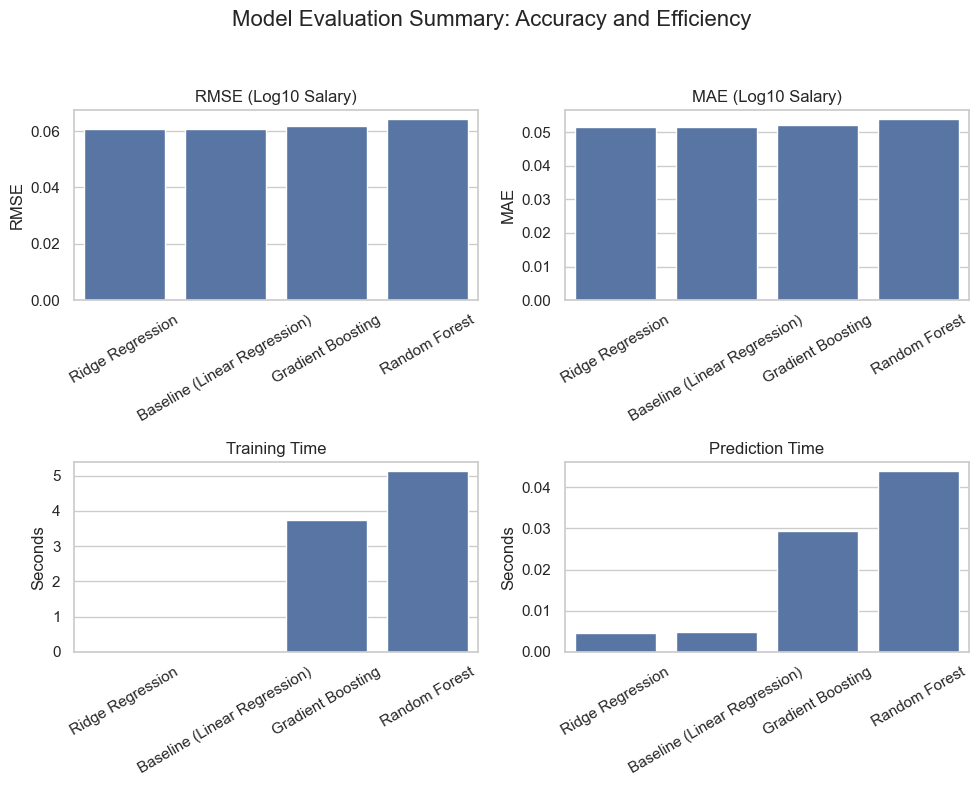

In [214]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Model Evaluation Summary: Accuracy and Efficiency", fontsize=16)

# RMSE
sns.barplot(
    data=results_df,
    x="Model",
    y="RMSE (log10)",
    ax=axes[0, 0]
)
axes[0, 0].set_title("RMSE (Log10 Salary)")
axes[0, 0].set_ylabel("RMSE")
axes[0, 0].set_xlabel("")
axes[0, 0].tick_params(axis="x", rotation=30)

# MAE
sns.barplot(
    data=results_df,
    x="Model",
    y="MAE (log10)",
    ax=axes[0, 1]
)
axes[0, 1].set_title("MAE (Log10 Salary)")
axes[0, 1].set_ylabel("MAE")
axes[0, 1].set_xlabel("")
axes[0, 1].tick_params(axis="x", rotation=30)

#Training Time
sns.barplot(
    data=results_df,
    x="Model",
    y="Train Time (s)",
    ax=axes[1, 0]
)
axes[1, 0].set_title("Training Time")
axes[1, 0].set_ylabel("Seconds")
axes[1, 0].set_xlabel("")
axes[1, 0].tick_params(axis="x", rotation=30)

#Prediction Time
sns.barplot(
    data=results_df,
    x="Model",
    y="Predict Time (s)",
    ax=axes[1, 1]
)
axes[1, 1].set_title("Prediction Time")
axes[1, 1].set_ylabel("Seconds")
axes[1, 1].set_xlabel("")
axes[1, 1].tick_params(axis="x", rotation=30)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### 10.7 Model Evaluation with USD Terms

In [215]:
results_df["Approx Avg Error (%)"] = (10 ** results_df["MAE (log10)"] - 1) * 100
median_salary = (10 ** y_test).median()

results_df["Approx Avg Error (USD)"] = (
    results_df["Approx Avg Error (%)"] / 100
) * median_salary
results_df["Approx RMSE Error (%)"] = (10 ** results_df["RMSE (log10)"] - 1) * 100

results_df["Approx RMSE Error (USD)"] = (
    results_df["Approx RMSE Error (%)"] / 100
) * median_salary
results_df

,Model,Train Time (s),Predict Time (s),MAE (log10),RMSE (log10),R²,Approx Avg Error (%),Approx Avg Error (USD),Approx RMSE Error (%),Approx RMSE Error (USD)
1,Ridge Regression,0.023364,0.004677,0.051626,0.060769,0.920351,12.622590,12609.462475,15.018811,15003.191049
0,Baseline (Linear Regression),0.026079,0.004852,0.051630,0.060771,0.920346,12.623675,12610.546213,15.019364,15003.743938
3,Gradient Boosting,3.729245,0.029311,0.052268,0.061639,0.918055,12.789435,12776.133747,15.249414,15233.554190
2,Random Forest,5.117330,0.043828,0.053868,0.064101,0.911377,13.205575,13191.841537,15.904681,15888.140606


### 11. Cross-Validation (Training Set Only)

Validate stability and robustness using k-fold cross-validation on the training data. The test set remains untouched for unbiased final evaluation.

In [216]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"MAE": "neg_mean_absolute_error", "RMSE": "neg_root_mean_squared_error", "R2": "r2"}

def cv_summary(name, pipeline):
    scores = cross_validate(
        pipeline, X_train, y_train,
        cv=cv, scoring=scoring, return_train_score=False
    )
    return {
        "Model": name,
        "CV_MAE_mean": (-scores["test_MAE"]).mean(),
        "CV_MAE_std": (-scores["test_MAE"]).std(),
        "CV_RMSE_mean": (-scores["test_RMSE"]).mean(),
        "CV_RMSE_std": (-scores["test_RMSE"]).std(),
        "CV_R2_mean": scores["test_R2"].mean(),
        "CV_R2_std": scores["test_R2"].std(),
    }

cv_results = pd.DataFrame([
    cv_summary("Baseline (Linear Regression)", baseline_pipeline),
    cv_summary("Ridge Regression", ridge_pipeline),
    cv_summary("Random Forest", rf_pipeline),
    cv_summary("Gradient Boosting (HistGB)", gb_pipeline),
]).sort_values("CV_RMSE_mean")

cv_results

,Model,CV_MAE_mean,CV_MAE_std,CV_RMSE_mean,CV_RMSE_std,CV_R2_mean,CV_R2_std
0,Baseline (Linear Regression),0.051716,0.000330,0.060872,0.000447,0.919937,0.001487
1,Ridge Regression,0.051723,0.000331,0.060882,0.000443,0.919913,0.001481
3,Gradient Boosting (HistGB),0.052685,0.000350,0.062717,0.000431,0.915012,0.001543
2,Random Forest,0.053937,0.000561,0.064355,0.000590,0.910527,0.000858


### 12. Grid Search
Grid search to tune key model hyperparameters via cross-validation, selecting the configuration that minimized RMSE on the training data.


In [217]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [218]:
ridge_param_grid = {
    "model__alpha": [0.1, 1.0, 10.0]
}
rf_param_grid = {
    "model__n_estimators": [200, 400]
}
gb_param_grid = {
    "model__learning_rate": [0.05, 0.1]
}

In [219]:
def run_simple_grid_search(name, pipeline, param_grid, X_train, y_train, cv):
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",  # primary metric
        cv=cv,
        n_jobs=-1,
        verbose=1,
        return_train_score=False
    )
    grid.fit(X_train, y_train)

    return grid

In [220]:
def evaluate_best_model_cv(name, best_estimator, X_train, y_train, cv):
    scoring = {
        "MAE": "neg_mean_absolute_error",
        "RMSE": "neg_root_mean_squared_error",
        "R2": "r2"
    }

    scores = cross_validate(
        best_estimator,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    return {
        "Model": name,
        "Best CV MAE (log10)": -scores["test_MAE"].mean(),
        "Best CV RMSE (log10)": -scores["test_RMSE"].mean(),
        "Best CV R²": scores["test_R2"].mean()
    }

In [221]:
ridge_grid = run_simple_grid_search(
    "Ridge Regression",
    ridge_pipeline,
    ridge_param_grid,
    X_train,
    y_train,
    cv
)

rf_grid = run_simple_grid_search(
    "Random Forest",
    rf_pipeline,
    rf_param_grid,
    X_train,
    y_train,
    cv
)

gb_grid = run_simple_grid_search(
    "Gradient Boosting (HistGB)",
    gb_pipeline,
    gb_param_grid,
    X_train,
    y_train,
    cv
)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [222]:
import pandas as pd

cv_summary_df = pd.DataFrame([
    evaluate_best_model_cv(
        "Ridge Regression",
        ridge_grid.best_estimator_,
        X_train,
        y_train,
        cv
    ),
    evaluate_best_model_cv(
        "Random Forest",
        rf_grid.best_estimator_,
        X_train,
        y_train,
        cv
    ),
    evaluate_best_model_cv(
        "Gradient Boosting (HistGB)",
        gb_grid.best_estimator_,
        X_train,
        y_train,
        cv
    ),
]).sort_values("Best CV RMSE (log10)")

cv_summary_df

,Model,Best CV MAE (log10),Best CV RMSE (log10),Best CV R²
0,Ridge Regression,0.051723,0.060882,0.919913
2,Gradient Boosting (HistGB),0.052685,0.062717,0.915012
1,Random Forest,0.053925,0.064344,0.910560


### 13. Final Model Selection
Select the final model based on test-set accuracy, cross-validation stability, computational efficiency, and interpretability.

In [223]:
best_model_name = results_df.iloc[0]["Model"]
best_model_name

'Ridge Regression'

Based on the held-out test set and cross-validation stability, the final model selected for salary prediction is **Ridge Regression**. Ridge provided the best overall balance of predictive accuracy (low RMSE and MAE on log10 salary), robust performance across folds, fast training and inference time, and interpretability through coefficient analysis.

### 14. Final Model Diagnostics (Ridge)

Run diagnostic plots to verify calibration and error behavior. Diagnostics are reported in USD for interpretability.

In [224]:
# Refit final Ridge model on full training data (ensures the latest fitted state)
ridge_pipeline.fit(X_train, y_train)
y_pred_ridge_log = ridge_pipeline.predict(X_test)

y_test_usd = 10 ** y_test
y_pred_ridge_usd = 10 ** y_pred_ridge_log

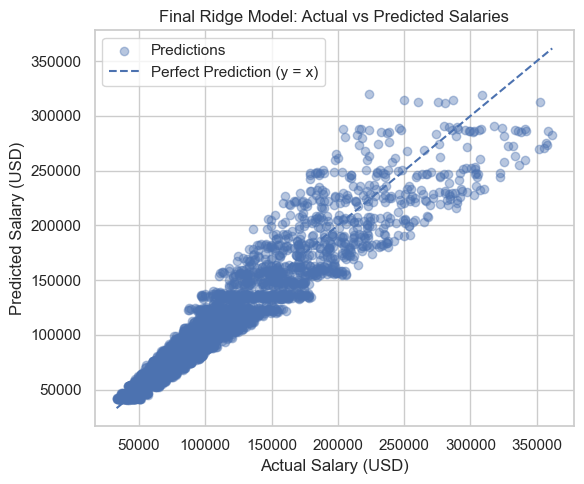

In [225]:
# Actual vs Predicted (USD)
plt.figure(figsize=(6, 5))
plt.scatter(y_test_usd, y_pred_ridge_usd, alpha=0.4, label="Predictions")
plt.plot(
    [y_test_usd.min(), y_test_usd.max()],
    [y_test_usd.min(), y_test_usd.max()],
    linestyle="--",
    label="Perfect Prediction (y = x)"
)
plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.title("Final Ridge Model: Actual vs Predicted Salaries")
plt.legend()
plt.tight_layout()
plt.show()


### 15. Coefficient Extraction and Interpretation (Ridge)

Extract model coefficients after one-hot encoding and interpret effects as approximate percentage salary changes (because the target is log10 salary).

In [226]:
# Extract feature names after preprocessing
preproc = ridge_pipeline.named_steps["preprocessing"]
model = ridge_pipeline.named_steps["model"]

cat_cols = preproc.transformers_[0][2]
num_cols = preproc.transformers_[1][2]

encoded_cat = preproc.named_transformers_["cat"].get_feature_names_out(cat_cols)
feature_names = list(encoded_cat) + list(num_cols)

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": model.coef_
})
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False)

# Convert log10 coefficient to approximate percentage change in salary
coef_df["Approx_%_Change_in_Salary"] = (10 ** coef_df["Coefficient"] - 1) * 100

coef_df.head(10)

,Feature,Coefficient,Abs_Coefficient,Approx_%_Change_in_Salary
53,company_location_Switzerland,0.189532,0.189532,54.714986
40,company_location_Denmark,0.149193,0.149193,40.991656
49,company_location_Norway,0.148659,0.148659,40.818231
1,experience_level_EX,0.144994,0.144994,39.634876
0,experience_level_EN,-0.117732,0.117732,-23.745010
4,experience_bucket_Entry,-0.117732,0.117732,-23.745010
37,company_location_Austria,-0.116833,0.116833,-23.586966
41,company_location_Finland,-0.113362,0.113362,-22.973820
46,company_location_Israel,-0.113131,0.113131,-22.932872
44,company_location_India,-0.113000,0.113000,-22.909617


### 16. Permutation Importance

Permutation importance to assess feature relevance by measuring the increase in prediction error when individual features are randomly shuffled. Features that cause a larger degradation in model performance are considered more influential, providing a model-agnostic validation of feature importance.

In [227]:
perm = permutation_importance(
    ridge_pipeline,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="neg_mean_absolute_error"
)

perm_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm.importances_mean
}).sort_values("Importance", ascending=False)

perm_df.head(10)

,Feature,Importance
6,company_location,0.075685
0,experience_level,0.072022
2,experience_bucket,0.046220
4,company_size,0.018679
1,years_experience,0.000404
7,remote_ratio,0.000119
3,job_title_grouped,0.000073
8,industry,0.000012
12,is_remote,0.000007
11,skill_count,0.000003


### 17. Bar Plot of Top Features
The bar plot shows the ten most influential predictors in the final Ridge regression model, with bar direction and magnitude indicating approximate percentage salary premiums or discounts.

In [228]:
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Approx_Salary_Impact_%": model.coef_
})

# Convert coefficients to percentage impact 
coef_df["Approx_Salary_Impact_%"] = (
    coef_df["Approx_Salary_Impact_%"] /
    np.sum(np.abs(coef_df["Approx_Salary_Impact_%"]))
) * 100

In [229]:
TOP_N = 10

top_features = (
    coef_df
    .sort_values("Approx_Salary_Impact_%", ascending=False)
    .head(TOP_N)
)

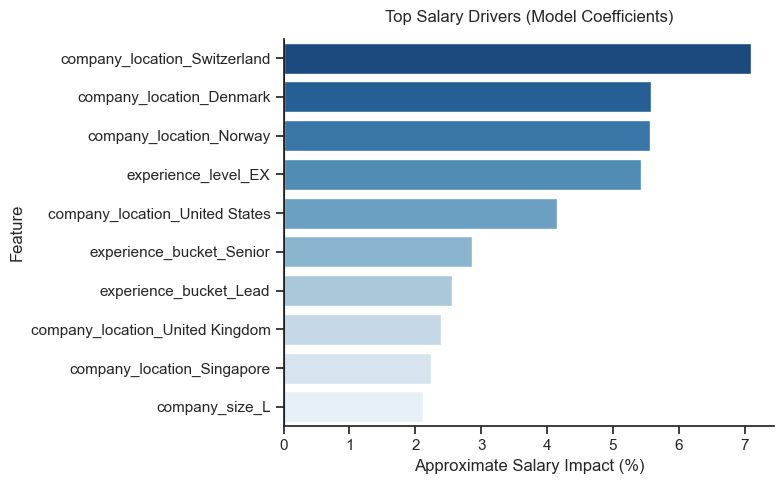

In [230]:
sns.set_theme(style="ticks", context="notebook")

plt.figure(figsize=(8, 5))

sns.barplot(
    data=top_features,
    x="Approx_Salary_Impact_%",
    y="Feature",
    hue="Feature",
    palette="Blues_r",
    legend=False
)

plt.axvline(0, color="black", linewidth=0.8)
sns.despine()

plt.title("Top Salary Drivers (Model Coefficients)", pad=12)
plt.xlabel("Approximate Salary Impact (%)")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()